In [1]:
# This code is written by Vincent Dufour-Decieux
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import scipy.stats
from scipy.optimize import fsolve
import math
import statsmodels.api as sm

# Get data

In [2]:
def get_idx_molecules(starting_molecules):
    idx_molecules = {}
    unique_molecules = np.unique(starting_molecules)
    for i in unique_molecules:
        idx_molecules[i] = np.where(starting_molecules == i)[0]
    return idx_molecules

In [3]:
# Loading the data
C_degree_eq_log = pd.read_csv('Data10reactionmodel/C_degree_eq_log.csv', index_col=[0]) # Array of the standard deviation of the degree distribution at equilibrium for the different simulations
CC_degrees_eq_log = pd.read_csv('Data10reactionmodel/CC_degrees_eq_log.csv', index_col=[0]) # Array of the standard deviation of the number of Ci_Cj bonds at equilibrium for the different simulations
CC_eq_log = pd.read_csv('Data10reactionmodel/CC_eq_log.csv', index_col=[0]) # Standard deviation of the number of C-C bonds at equilibrium for the different simulations
H2_eq_log = pd.read_csv('Data10reactionmodel/H2_eq_log.csv', index_col=[0]) # Standard deviation of the number of H-H bonds at equilibrium for the different simulations

C_degree_eq_log_std = pd.read_csv('Data10reactionmodel/C_degree_eq_log_std.csv', index_col=[0]) # Array of the standard deviation of the degree distribution at equilibrium for the different simulations
CC_degrees_eq_log_std = pd.read_csv('Data10reactionmodel/CC_degrees_eq_log_std.csv', index_col=[0]) # Array of the standard deviation of the number of Ci_Cj bonds at equilibrium for the different simulations
CC_eq_log_std = pd.read_csv('Data10reactionmodel/CC_eq_log_std.csv', index_col=[0]) # Standard deviation of the number of C-C bonds at equilibrium for the different simulations
H2_eq_log_std = pd.read_csv('Data10reactionmodel/H2_eq_log_std.csv', index_col=[0]) # Standard deviation of the number of H-H bonds at equilibrium for the different simulations

# For each simulation, define the temperature and the starting molecules (same order as loaded data)
temperatures = np.array([3200, 3200, 3300, 3300, 3400, 3400, 3500, 3500, 3600, 3600, 4000, 4000, 4500, 4500, 5000, 5000, 3300, 3300, 4000, 4000, 3600, 3600, 3300, 3300, 3500, 3500, 4500, 4500, 3600, 3600, 4000, 4000, 4000, 4000]) # Temperature of the different simulations (in the same order as previous arrays)
starting_molecules = np.array(['C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C4H10', 'C2H6', 'C2H6', 'C2H6', 'C2H6', 'CH4', 'CH4', 'C8H18', 'C8H18', 'mix', 'mix', 'CH4', 'CH4', 'C4H10_1120at', 'C4H10_1120at', 'C2H6_1280at', 'C2H6_1280at', 'C8H18_1040at', 'C8H18_1040at']) # Temperature of the different simulations (in the same order as previous arrays)
unique_molecules = np.unique(starting_molecules)
names_molecules = {'C4H10': 'C$_4$H$_{10}$', 'C2H6': 'C$_2$H$_{6}$', 'CH4': 'CH$_{4}$', 'C8H18': 'C$_8$H$_{18}$', 'mix': 'mix'}

# Define which data are in the training data
training_data = np.where(starting_molecules == 'C4H10')[0][:-2]

# Input which simulations are in the exact same conditions.
same_conditions = np.array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16])
unique_conditions = np.unique(same_conditions)
name_unique_conditions = {0:'C$_4$H$_{10}$ 3,200K', 1:'C$_4$H$_{10}$ 3,300K', 2:'C$_4$H$_{10}$ 3,400K', 
                          3:'C$_4$H$_{10}$ 3,500K', 4:'C$_4$H$_{10}$ 3,600K', 5:'C$_4$H$_{10}$ 4,000K', 
                          6:'C$_4$H$_{10}$ 4,500K', 7:'C$_4$H$_{10}$ 5,000K', 8:'C$_2$H$_{6}$ 3,300K', 
                          9:'C$_2$H$_{6}$ 4,000K', 10:'CH$_{4}$ 3,600K', 11:'C$_8$H$_{18}$ 3,300K', 
                          12:'mix 3,500K', 13: 'CH$_{4}$ 4,500K', 14: 'C$_4$H$_{10}$ 3,600K 1120at', 15:'C$_2$H$_6$ 4,000K 1280at',
                          16: 'C$_8$H$_{18}$ 4,000K 1040at'}
colors = {'C4H10': 'tab:orange', 'C2H6': 'tab:blue', 'CH4': 'tab:green', 'C8H18': 'k', 'mix': 'tab:purple'}
idx_molecules = get_idx_molecules(starting_molecules)

# Define the number of atoms for each unique conditions. In order [# of H, # of C, # of C-C bonds, # of H-H bonds, # of C-H bonds]
init_conditions = {'C4H10': np.array([640, 256, 3*64, 0, 640]), 'C2H6': np.array([6*125, 250, 125, 0, 6*125]), 'CH4': np.array([4*160, 160, 0, 0, 4*160]), 'C8H18': np.array([18*36, 8*36, 7*36, 0, 18*36]), 'mix': np.array([732, 240, 146, 32, 668]), 'C3H8': np.array([90*8, 90*3, 90*2, 0, 90*8]),
                   'C4H10_1120at': np.array([80*10, 80*4, 3*80, 0, 80*10]), 'C2H6_1280at': np.array([160*6, 160*2, 160, 0, 160*6]), 'C8H18_1040at':np.array([40*18, 40*8, 40*7, 0, 40*18])} # Dictionnary of the initial conditions for the simulations starting with different molecules. The values of the dictionary are arrays of [# of initial H atoms, # of initial C atoms, # of initial C-C bonds, # of initial H-H bonds, # of initial C-H bonds]

# Name of the reactions considered
names_reax = [r'$C_{0}-H + C_{0}-H \rightarrow C_{1}-C_{1} + H-H$', 
              r'$C_{0}-H + C_{1}-H \rightarrow C_{1}-C_{2} + H-H$',
              r'$C_{0}-H + C_{2}-H \rightarrow C_{1}-C_{3} + H-H$',
              r'$C_{0}-H + C_{3}-H \rightarrow C_{1}-C_{4} + H-H$',
              r'$C_{1}-H + C_{1}-H \rightarrow C_{2}-C_{2} + H-H$',
              r'$C_{1}-H + C_{2}-H \rightarrow C_{2}-C_{3} + H-H$',
              r'$C_{1}-H + C_{3}-H \rightarrow C_{2}-C_{4} + H-H$',
              r'$C_{2}-H + C_{2}-H \rightarrow C_{3}-C_{3} + H-H$',
              r'$C_{2}-H + C_{3}-H \rightarrow C_{3}-C_{4} + H-H$',
              r'$C_{3}-H + C_{3}-H \rightarrow C_{4}-C_{4} + H-H$']

# H/C ratio for each unique conditions.
HC_ratio = {'C4H10': 10/4, 'C2H6': 3, 'CH4': 4, 'C8H18': 18/8, 'mix': 732/240, 'C4H10_1120at':10/4, 'C2H6_1280at': 6/2, 'C8H18_1040at': 18/8} 

# Compute the K's

In [4]:
# Definition of the different K_ij and calculation of the uncertainty of their values using bootstrap
num_samples = 1000
K_samples = np.zeros([10, num_samples])
K = np.zeros([C_degree_eq_log.shape[1], 10, 2])

for i in range(C_degree_eq_log.shape[1]):
    
    # Sample num_samples of the log of the number of degrees in a Gaussian.
    degree_0 = np.random.normal(loc = C_degree_eq_log.iloc[0, i], scale = C_degree_eq_log_std.iloc[0, i], size = num_samples)
    degree_1 = np.random.normal(loc = C_degree_eq_log.iloc[1, i], scale = C_degree_eq_log_std.iloc[1, i], size = num_samples)
    degree_2 = np.random.normal(loc = C_degree_eq_log.iloc[2, i], scale = C_degree_eq_log_std.iloc[2, i], size = num_samples)
    degree_3 = np.random.normal(loc = C_degree_eq_log.iloc[3, i], scale = C_degree_eq_log_std.iloc[3, i], size = num_samples)
    degree_4 = np.random.normal(loc = C_degree_eq_log.iloc[4, i], scale = C_degree_eq_log_std.iloc[4, i], size = num_samples)
    CC = np.random.normal(loc = CC_eq_log.iloc[0, i], scale = CC_eq_log_std.iloc[0, i], size = num_samples)
    HH = np.random.normal(loc = H2_eq_log.iloc[0, i], scale = H2_eq_log_std.iloc[0, i], size = num_samples)
    
    # Compute the K's for each of the num_samples value
    K_samples[0] = np.log10(1) + degree_1 + degree_1 + HH - (np.log10(4) + CC + np.log10(4) + degree_0 + np.log10(4) + degree_0)
    K_samples[1] = np.log10(4) + degree_1 + degree_2 + HH - (np.log10(4) + CC + np.log10(4) + degree_0 + np.log10(3) + degree_1)
    K_samples[2] = np.log10(6) + degree_1 + degree_3 + HH - (np.log10(4) + CC + np.log10(4) + degree_0 + np.log10(2) + degree_2)
    K_samples[3] = np.log10(8) + degree_1 + degree_4 + HH - (np.log10(4) + CC + np.log10(4) + degree_0 + np.log10(1) + degree_3)
    K_samples[4] = np.log10(4) + degree_2 + degree_2 + HH - (np.log10(4) + CC + np.log10(3) + degree_1 + np.log10(3) + degree_1)
    K_samples[5] = np.log10(12) + degree_2 + degree_3 + HH - (np.log10(4) + CC + np.log10(3) + degree_1 + np.log10(2) + degree_2)
    K_samples[6] = np.log10(16) + degree_2 + degree_4 + HH - (np.log10(4) + CC + np.log10(3) + degree_1 + np.log10(1) + degree_3)
    K_samples[7] = np.log10(9) + degree_3 + degree_3 + HH - (np.log10(4) + CC + np.log10(2) + degree_2 + np.log10(2) + degree_2)
    K_samples[8] = np.log10(24) + degree_3 + degree_4 + HH - (np.log10(4) + CC + np.log10(2) + degree_2 + np.log10(1) + degree_3)
    K_samples[9] = np.log10(16) + degree_4 + degree_4 + HH - (np.log10(4) + CC + np.log10(1) + degree_3 + np.log10(1) + degree_3)
    
    # Compute the mean and the standard deviation of the samples of K. 
    K[i, :, 0] = np.mean(K_samples, axis=1)
    K[i, :, 1] = np.std(K_samples, axis=1)
     

In [5]:
def linear_bootstrap_measurement_error(reax, K, temperature_goal, alpha, num_of_test, training_data, temperature):
    # Compute the confidence and prediction interval of the Arrhenius plot of the K's using a bootstrap method. 
    points_temp = np.zeros([training_data.shape[0], num_of_test])
    results_bootstrap = np.zeros([temperature_goal.shape[0], num_of_test, 5])
    for j in range(training_data.shape[0]):
        points_temp[j] = scipy.stats.norm.rvs(size=num_of_test, loc=K[training_data[j], reax, 0], scale = K[training_data[j], reax, 1])
    for i in range(num_of_test):
        x =  sm.add_constant(1/temperature[training_data])
        y = points_temp[:, i]
        x_goal = sm.add_constant(1/temperature_goal)
        lm_fit = sm.OLS(y, x).fit()
        dt = lm_fit.get_prediction(x_goal).summary_frame(alpha = alpha)
        results_bootstrap[:, i, 0] = np.array(dt['mean'])
        results_bootstrap[:, i, 1] = np.array(dt['mean_ci_lower'])
        results_bootstrap[:, i, 2] = np.array(dt['mean_ci_upper'])
        results_bootstrap[:, i, 3] = np.array(dt['obs_ci_lower'])
        results_bootstrap[:, i, 4] = np.array(dt['obs_ci_upper'])
    results = np.zeros([temperature_goal.shape[0], 5])
    results[:, 0] = np.mean(results_bootstrap[:, :, 0], axis=1)
    results[:, 1] = np.mean(results_bootstrap[:, :, 1], axis=1)
    results[:, 2] = np.mean(results_bootstrap[:, :, 2], axis=1)
    results[:, 3] = np.mean(results_bootstrap[:, :, 3], axis=1)
    results[:, 4] = np.mean(results_bootstrap[:, :, 4], axis=1)
    return results

In [6]:
# Fitting of the A_ij and B_ij which are the slopes and the intercept of log(K_ij) vs 1/T
slope = np.zeros([10])
intercept = np.zeros([10])
temperature_goal = np.arange(3100, 5100, 100)
alpha = 0.05
num_of_test = 1000
bootstrap_results = np.zeros([10, temperature_goal.shape[0], 5])
for i in range(10):
    slope[i], intercept[i], r_value, p_value, std_err = scipy.stats.linregress(1/temperatures[training_data], K[training_data, i, 0])
    bootstrap_results[i] = linear_bootstrap_measurement_error(i, K, temperature_goal, alpha, num_of_test, training_data, temperatures)


# Plot the K's

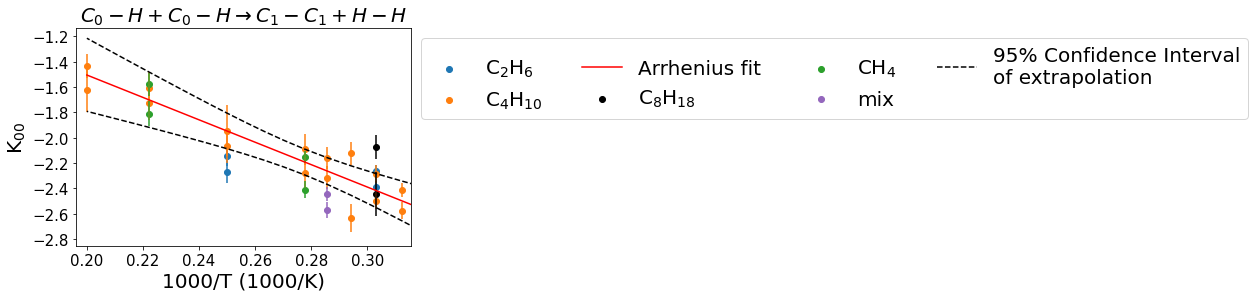

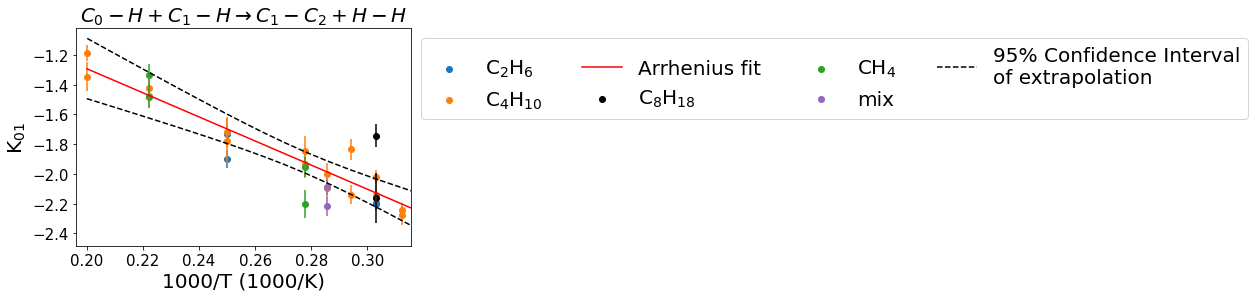

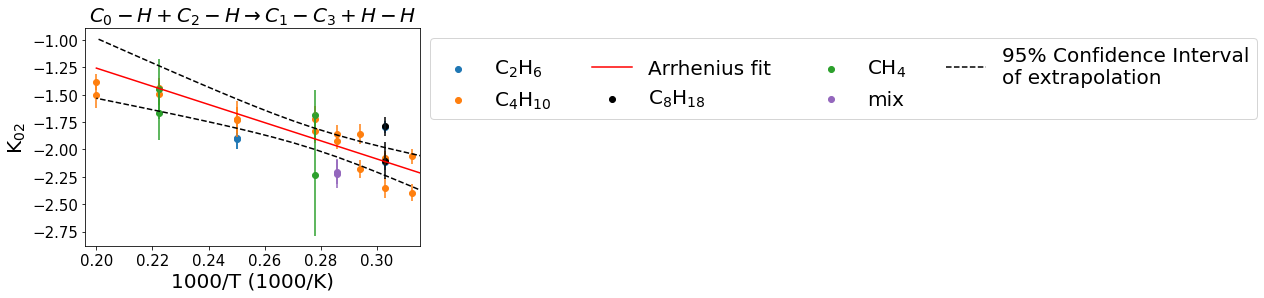

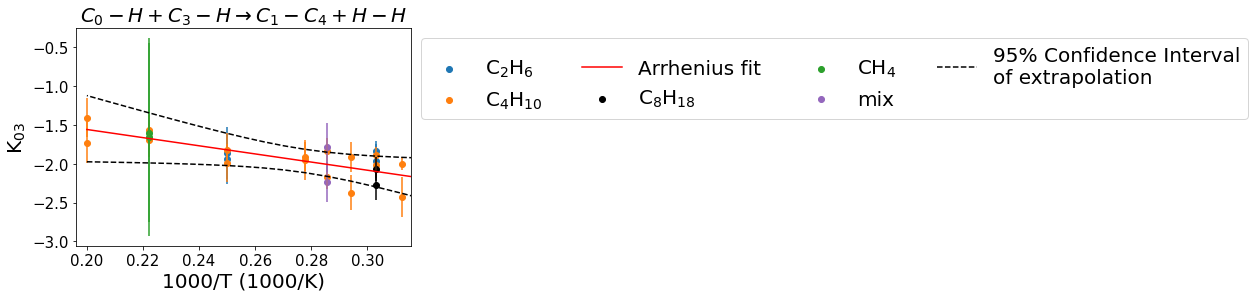

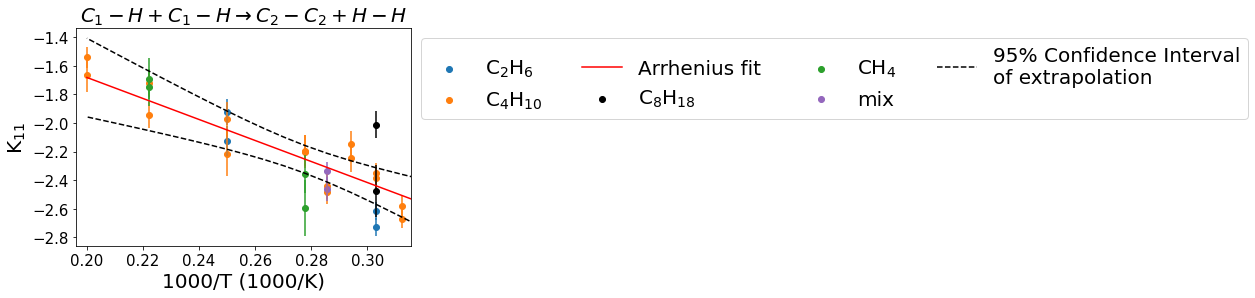

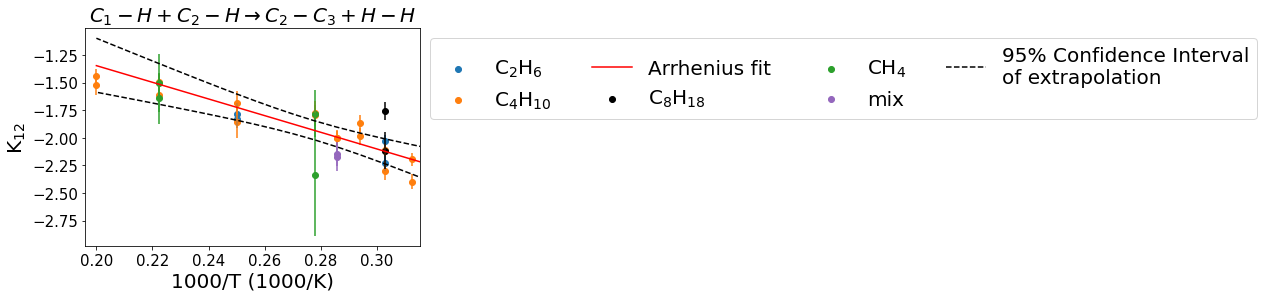

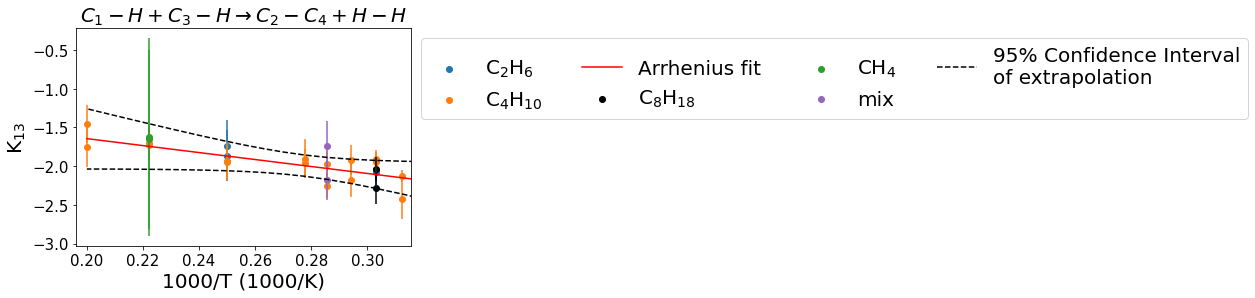

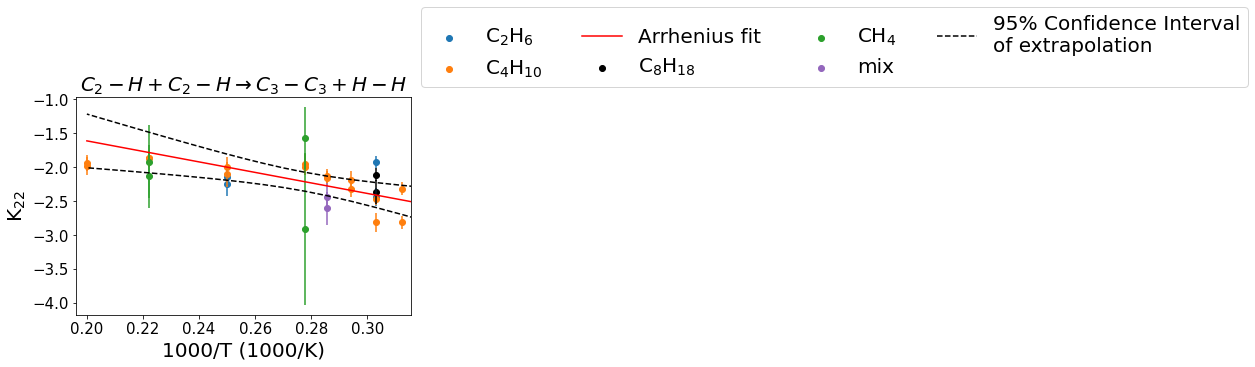

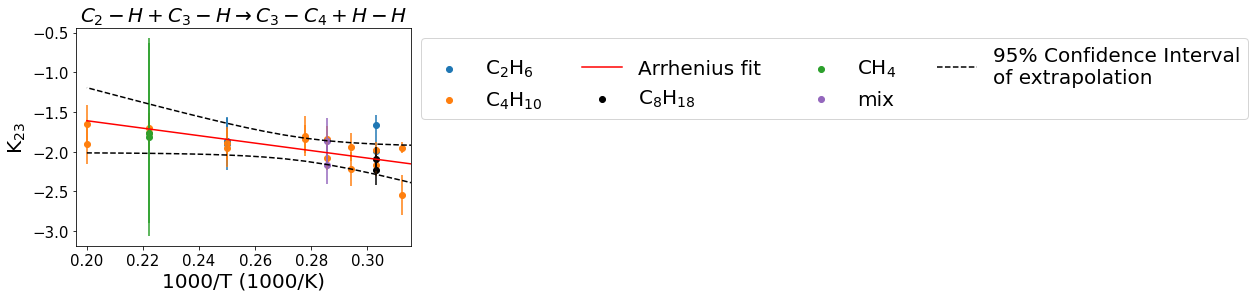

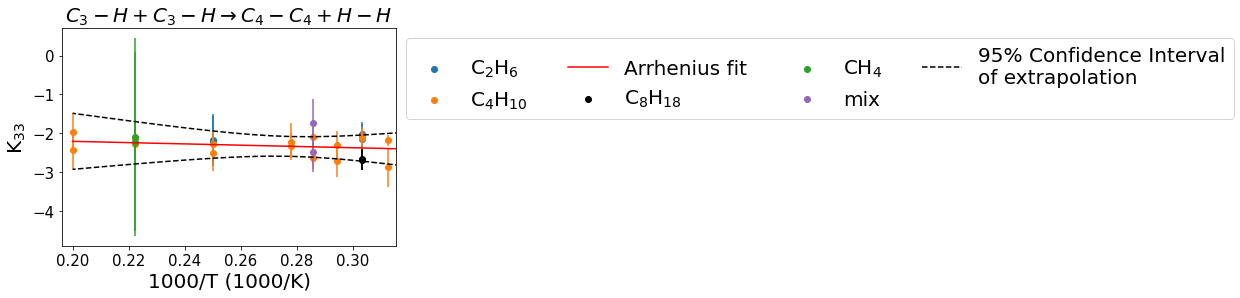

In [7]:
# Plot of the K_ij vs temperature 
K_names = [r"K$_{00}$", r'K$_{01}$', r'K$_{02}$', r'K$_{03}$', r'K$_{11}$', 
           r'K$_{12}$', r'K$_{13}$', r'K$_{22}$', r'K$_{23}$', r'K$_{33}$']
for i in range(10):
    plt.figure(i)
    for j in unique_molecules:
        if j[-1] != 't':
            plt.scatter(1000/temperatures[idx_molecules[j]], K[idx_molecules[j], i, 0], 
                        c=colors[j], label = names_molecules[j])
            plt.errorbar(1000/temperatures[idx_molecules[j]], K[idx_molecules[j], i, 0],
                         K[idx_molecules[j], i, 1], c=colors[j], 
                         fmt='none')
        
    plt.xlim([1000/5100, 1000/3170])
    plt.plot(1000/temperature_goal, slope[i]/temperature_goal + intercept[i], c='r', label='Arrhenius fit')
#     plt.plot(1000/np.arange(2800, 6500, 100), slope[i]/np.arange(2800, 6500, 100) + intercept[i], c='r')
    
    plt.plot(1000/temperature_goal, bootstrap_results[i, :, 1], c = 'k', linestyle='--', label='95% Confidence Interval\nof extrapolation', zorder=2)
    plt.plot(1000/temperature_goal, bootstrap_results[i, :, 2], c = 'k', linestyle='--', zorder=2)
    
    plt.title(names_reax[i], fontsize=20)
    handles, labels = plt.gca().get_legend_handles_labels()

#     specify order of items in legend
    order = [0, 1,5, 2,3,4, 6]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, bbox_to_anchor=(1, 1), ncol=4)
    plt.xlabel('1000/T (1000/K)', fontsize=20)
    plt.ylabel(K_names[i], fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig('K_vs_T_reaction_' + str(i), dpi=300, bbox_inches='tight')

# Predict degree distributions

In [8]:
# Equations to solve. It gives x which is the number of total reactions after equilibrium and y which is the number of total carbon with degree 0 at equilibrium
def equations(p, K, N_H, N_C, N_CC_0, N_HH_0):
    x, y = p
    return (y*(1 + 8*np.sqrt(K[0]*(N_CC_0 + x)/(N_HH_0 + x)) + 12*K[1]*(N_CC_0 + x)/(N_HH_0 + x) + 16*np.sqrt(K[0])*K[5]*(N_CC_0 + x)**1.5/(N_HH_0 + x)**1.5 + 4*K[1]*K[8]*(N_CC_0 + x)**2/(N_HH_0 + x)**2) - N_C,  
            2*(N_HH_0 + x) + 4*y + 24*y*np.sqrt(K[0]*(N_CC_0 + x)/(N_HH_0 + x)) + 24*K[1]*y*(N_CC_0 + x)/(N_HH_0 + x) + 16*np.sqrt(K[0])*K[5]*y*(N_CC_0 + x)**1.5/(N_HH_0 + x)**1.5 - N_H)


In [9]:
# Get the degree distributions from N_C0 (=Number of carbon with degree 0), X (=Number of CC bonds at eq/Number of HH bonds at eq) and the K_ijs
def degrees(N_C0, X, K):
    N_C1 = 8*np.sqrt(K[0])*N_C0*np.sqrt(X)
    N_C2 = 12*K[1]*X*N_C0
    N_C3 = 16*np.sqrt(K[0])*K[5]*X**1.5*N_C0
    N_C4 = 4*K[1]*K[8]*X**2*N_C0
    return [N_C0, N_C1, N_C2, N_C3, N_C4]

In [10]:
# Get the predicted degree distribution at equilibrium for the different simulation
results = pd.DataFrame(0, columns=['Degree 0', 'Degree 1', 'Degree 2', 'Degree 3', 'Degree 4', 'CC bonds', 'H2'], 
                       index=C_degree_eq_log.columns)
results_std = pd.DataFrame(0, columns=['Degree 0', 'Degree 1', 'Degree 2', 'Degree 3', 'Degree 4', 'CC bonds', 'H2'],
                           index=C_degree_eq_log.columns)

num_samples = 1000
for i in range(results.shape[0]):
    print(i)
    
    init = init_conditions[starting_molecules[i]] # Initial condition of the simulation: [# of initial H atoms, # of initial C atoms, # of initial C-C bonds, # of initial H-H bonds, # of initial C-H bonds]
    samples = np.zeros([results.shape[1], num_samples])
    
    for j in range(num_samples):
        K_temp = np.zeros([10])
        idx_temp = np.where(temperature_goal == temperatures[i])[0][0]
        
        # Samples the equilibrium constant in the distribution at the temperature of interest. 
        for k in range(10):
            K_temp[k] = 10**np.random.normal(loc = slope[k]/temperatures[i] + intercept[k], 
                                             scale = abs(bootstrap_results[k, idx_temp, 1] 
                                                         - bootstrap_results[k, idx_temp, 0])/1.96)
        
        x, y =  fsolve(equations, (1, 30), args=(K_temp, init[0], init[1], init[2], init[3])) # Solve the equation to obtain the total # of equations at equilibrium and the # of carbon at degree 0 at equilbrium
        X = (init[2] + x)/(init[3] + x) # Ratio (# of CC bonds at eq)/(# of HH bonds at eq)
        degrees_distrib = degrees(y, X, K_temp) # Obtain all the degree distributions at eq
        CC = init[2] + x # # of CC bonds at eq
        H2 = init[3] + x # # of HH bonds at eq
        
        samples[-1, j] = H2
        samples[-2, j] = CC
        samples[:5, j] = degrees_distrib
        
    # Store the mean and the standard deviation of the results
    results['H2'].iloc[i] = np.mean(samples[-1])
    results['CC bonds'].iloc[i] = np.mean(samples[-2])
    results.iloc[i, :5] = np.mean(samples[:5], axis=1)
    
    results_std['H2'].iloc[i] = np.std(samples[-1])
    results_std['CC bonds'].iloc[i] = np.std(samples[-2])
    results_std.iloc[i, :5] = np.std(samples[:5], axis=1)

results.to_csv('Pred_10reactions_with_bootstrap')
results_std.to_csv('Pred_std_10reactions_with_bootstrap')


0


/var/folders/bp/d53fd2692h15rcqyj4ry3ybw0000gn/T/ipykernel_10904/4239065062.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['CC bonds'].iloc[i] = np.mean(samples[-2])
/var/folders/bp/d53fd2692h15rcqyj4ry3ybw0000gn/T/ipykernel_10904/4239065062.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_std['CC bonds'].iloc[i] = np.std(samples[-2])


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25

/var/folders/bp/d53fd2692h15rcqyj4ry3ybw0000gn/T/ipykernel_10904/2978603741.py:4: RuntimeWarning: invalid value encountered in sqrt
  return (y*(1 + 8*np.sqrt(K[0]*(N_CC_0 + x)/(N_HH_0 + x)) + 12*K[1]*(N_CC_0 + x)/(N_HH_0 + x) + 16*np.sqrt(K[0])*K[5]*(N_CC_0 + x)**1.5/(N_HH_0 + x)**1.5 + 4*K[1]*K[8]*(N_CC_0 + x)**2/(N_HH_0 + x)**2) - N_C,
/var/folders/bp/d53fd2692h15rcqyj4ry3ybw0000gn/T/ipykernel_10904/2978603741.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return (y*(1 + 8*np.sqrt(K[0]*(N_CC_0 + x)/(N_HH_0 + x)) + 12*K[1]*(N_CC_0 + x)/(N_HH_0 + x) + 16*np.sqrt(K[0])*K[5]*(N_CC_0 + x)**1.5/(N_HH_0 + x)**1.5 + 4*K[1]*K[8]*(N_CC_0 + x)**2/(N_HH_0 + x)**2) - N_C,
/var/folders/bp/d53fd2692h15rcqyj4ry3ybw0000gn/T/ipykernel_10904/2978603741.py:5: RuntimeWarning: invalid value encountered in sqrt
  2*(N_HH_0 + x) + 4*y + 24*y*np.sqrt(K[0]*(N_CC_0 + x)/(N_HH_0 + x)) + 24*K[1]*y*(N_CC_0 + x)/(N_HH_0 + x) + 16*np.sqrt(K[0])*K[5]*y*(N_CC_0 + x)**1.5/(N_HH_0 + x)**1.5 - N_H)


26
27
28
29
30
31
32
33


# Bar plots only with degrees

In [11]:
# Get the predicted results in percentage instead of counts

results_degree = results[['Degree 0', 'Degree 1', 'Degree 2', 'Degree 3', 'Degree 4']].T \
                 /np.sum(results[['Degree 0', 'Degree 1', 'Degree 2', 'Degree 3', 'Degree 4']], axis=1)

results_degree_std = results_std[['Degree 0', 'Degree 1', 'Degree 2', 'Degree 3', 'Degree 4']].T\
                     /np.sum(results[['Degree 0', 'Degree 1', 'Degree 2', 'Degree 3', 'Degree 4']], axis=1)


In [12]:
# Get the real results in percentage instead of log10(counts)

C_degree = 10**C_degree_eq_log \
           /np.sum(10**C_degree_eq_log.T[['Degree 0', 'Degree 1', 'Degree 2', 'Degree 3', 'Degree 4']], axis=1)
C_degree_std = 10**C_degree_eq_log_std \
               /np.sum(10**C_degree_eq_log.T[['Degree 0', 'Degree 1', 'Degree 2', 'Degree 3', 'Degree 4']], axis=1)

In [13]:
# Compute the difference between predictions and real values for the degrees
res_tot = abs(C_degree - results_degree)

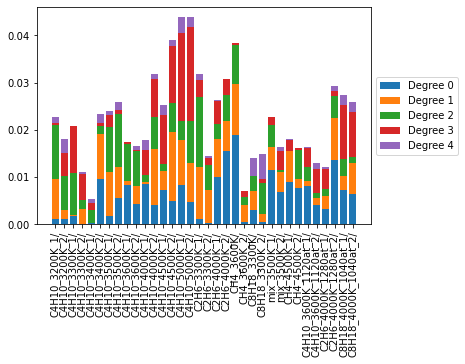

In [14]:
# Plot the differences in bar plots
plt.figure(0)
for i in range(5):
    if i > 0:
        plt.bar(res_tot.columns, res_tot.iloc[i]/4, 
                bottom = np.sum(res_tot.iloc[:i]/4, axis=0), label=res_tot.index[i])
    else:
        plt.bar(res_tot.columns, res_tot.iloc[i]/4, label=res_tot.index[i])
        plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1, 0.7))

# H/C vs T plot

In [15]:
res_tot_2 = np.zeros([unique_conditions.shape[0], 5])
temperatures_2 = np.zeros([unique_conditions.shape[0]])
HC_ratio_2 = np.zeros([unique_conditions.shape[0]])

for i in range(unique_conditions.shape[0]):
    idx = np.where(same_conditions == unique_conditions[i])[0]
    res_tot_2[i] = np.mean(res_tot.iloc[:, idx], axis=1)
    temperatures_2[i] = temperatures[idx[0]]
    HC_ratio_2[i] = HC_ratio[starting_molecules[idx[0]]]

/var/folders/bp/d53fd2692h15rcqyj4ry3ybw0000gn/T/ipykernel_10904/3258694187.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('HCratio_vs_T_error.pdf', fmt='pdf', bbox_inches='tight')


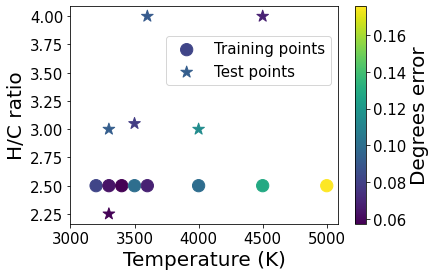

In [16]:
plt.figure(0)
min_ = np.min(np.sum(res_tot_2, axis=1))
max_ = np.max(np.sum(res_tot_2, axis=1))
plt.scatter(temperatures_2[:8], HC_ratio_2[:8], c = np.sum(res_tot_2, axis=1)[:8],cmap='viridis',label='Training points', s=150)
plt.clim(min_, max_)
plt.scatter(temperatures_2[8:-3], HC_ratio_2[8:-3], c = np.sum(res_tot_2, axis=1)[8:-3], cmap='viridis',marker='*', label='Test points', s=150)
plt.clim(min_, max_)
# plt.colorbar().set_label('Degrees error',rotation=270)

cbar = plt.colorbar()
cbar.set_label('Degrees error', fontsize=20)
cbar.ax.tick_params(labelsize=15)
plt.xlabel('Temperature (K)', fontsize=20)
plt.ylabel('H/C ratio', fontsize=20)
plt.xticks([3000, 3500, 4000, 4500, 5000], fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1, 0.9))
plt.savefig('HCratio_vs_T_error', dpi=300, bbox_inches='tight')
plt.savefig('HCratio_vs_T_error.pdf', fmt='pdf', bbox_inches='tight')
# plt.show()

# Comparison predicted data with MD data bar plots

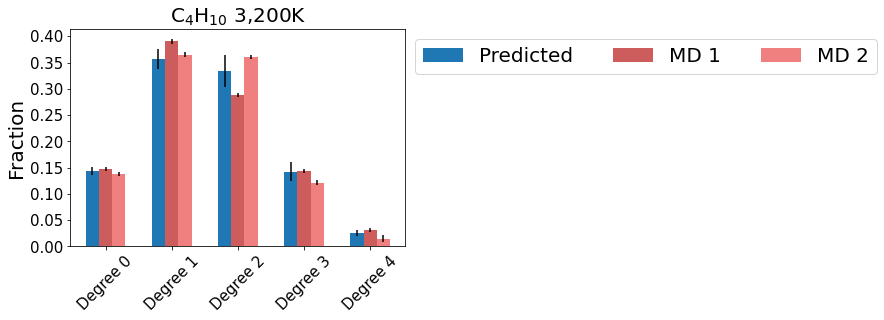

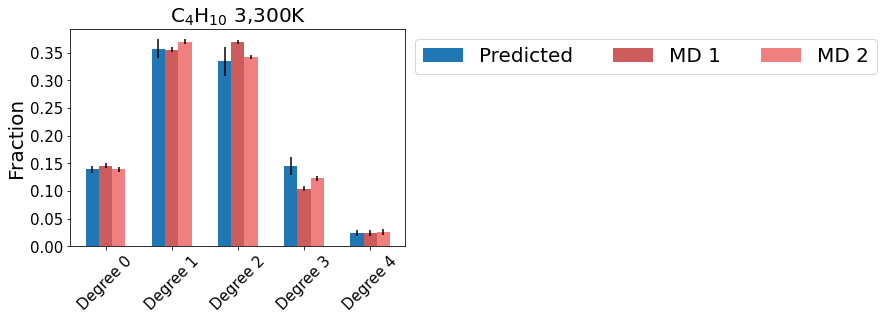

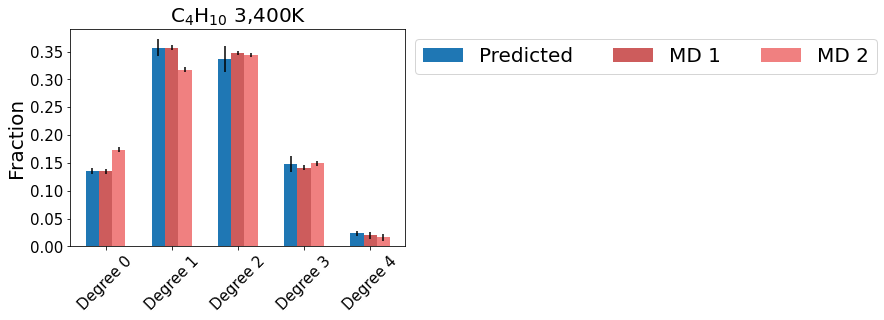

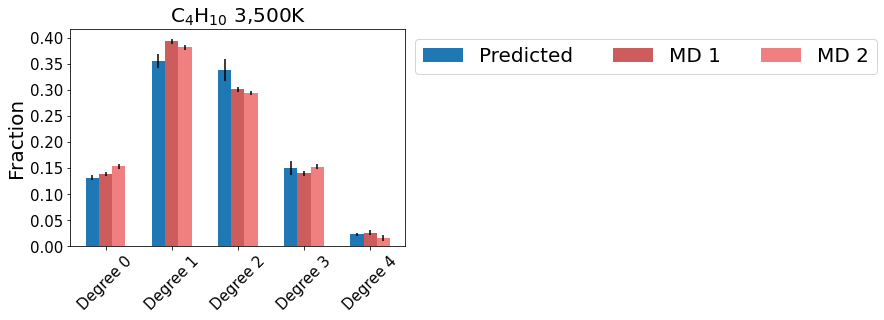

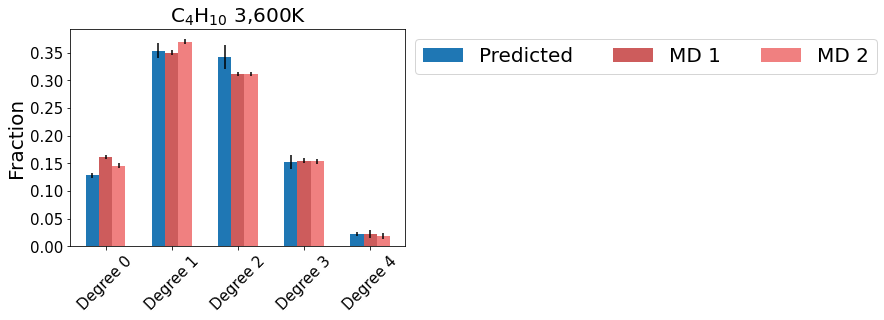

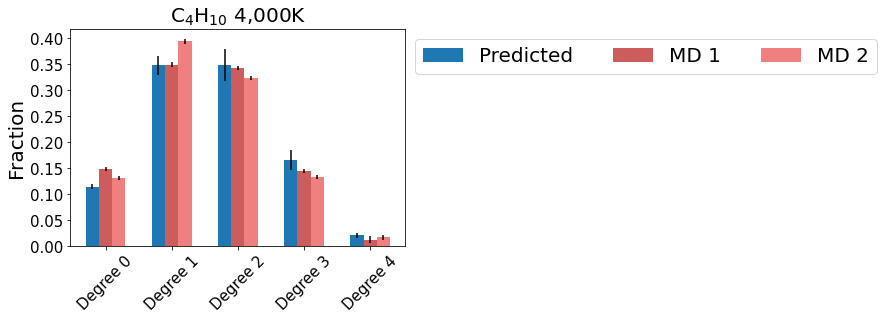

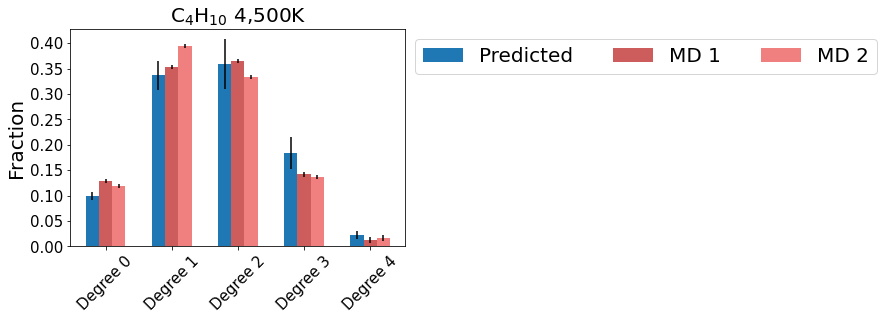

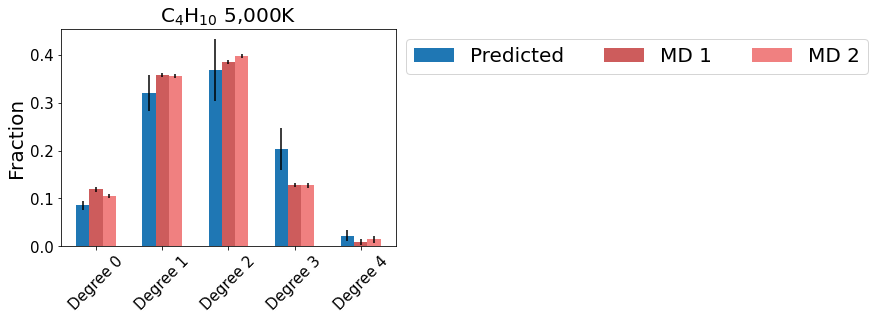

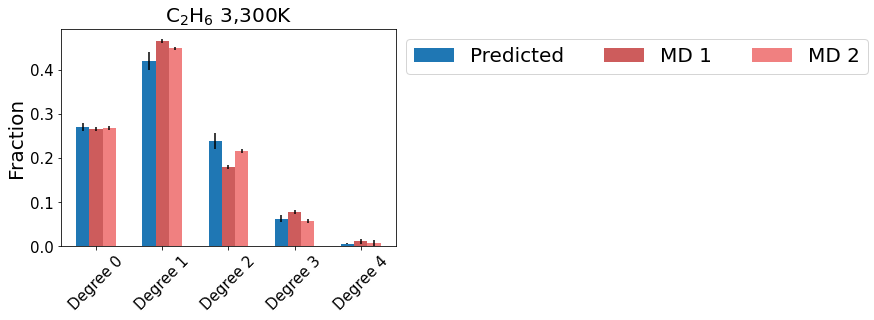

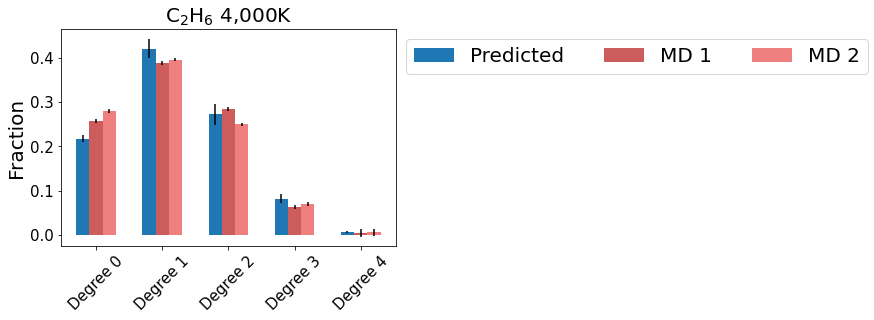

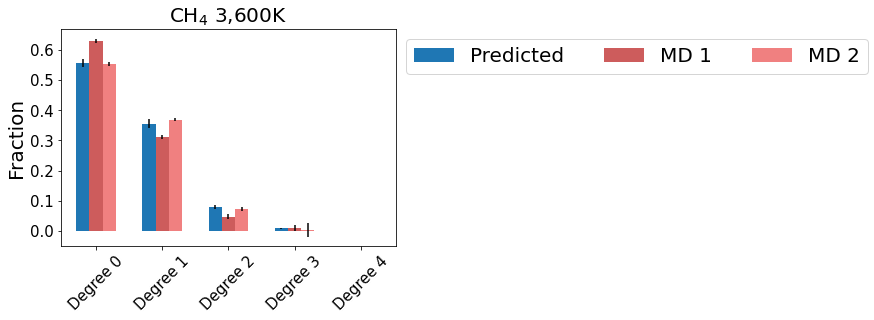

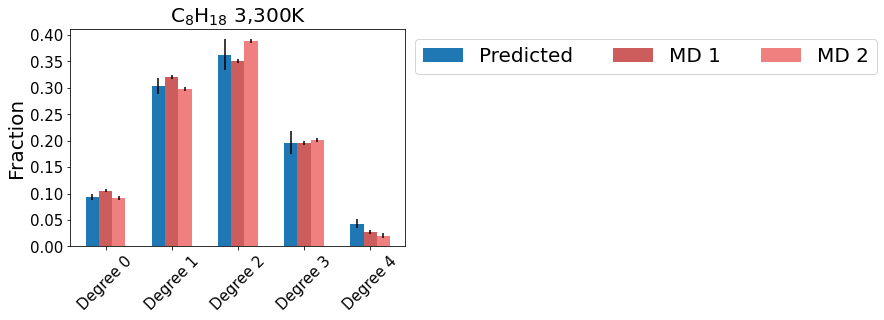

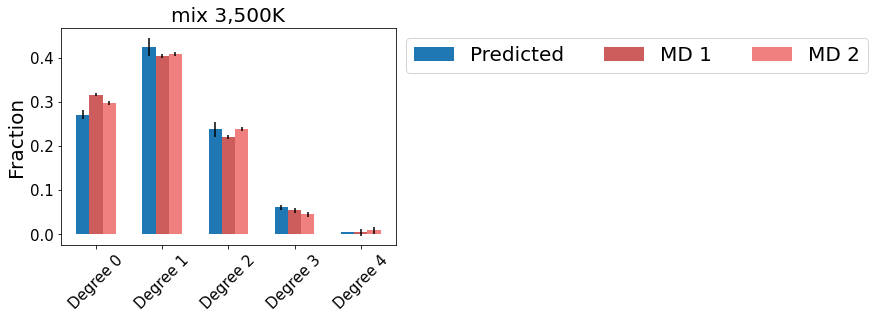

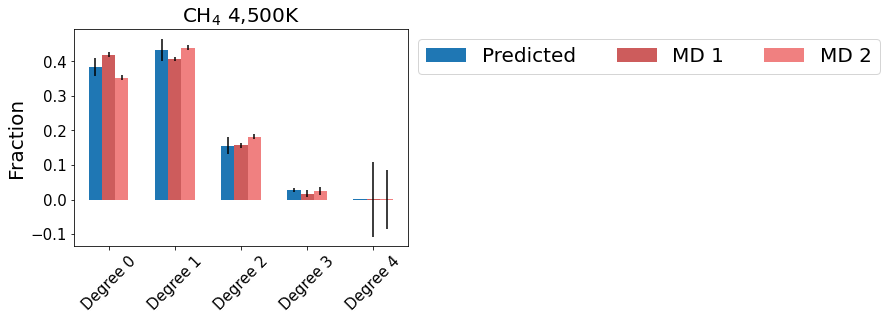

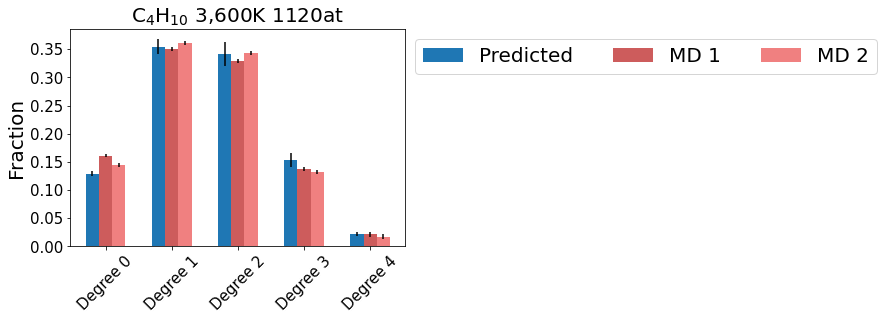

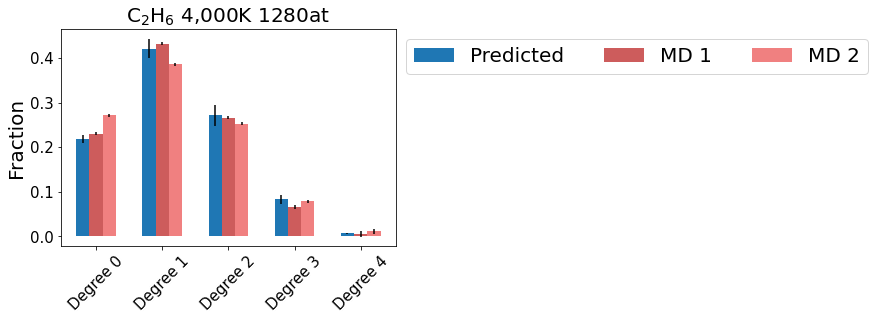

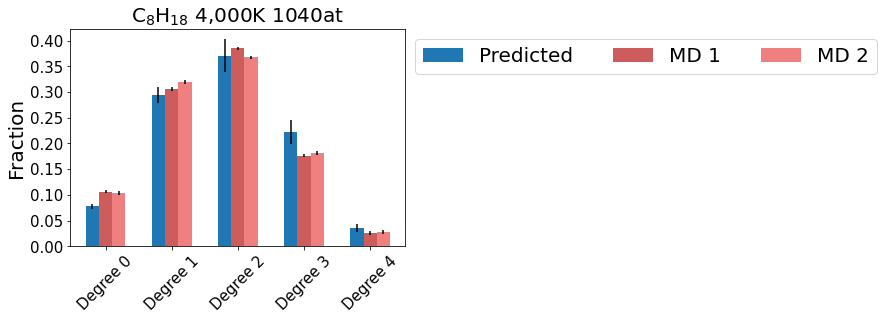

In [17]:
# Get the predicted degree distribution at equilibrium for the different simulation
results = pd.DataFrame(0, columns=['Degree 0', 'Degree 1', 'Degree 2', 'Degree 3', 'Degree 4', 'CC bonds', 'H2'], 
                       index=C_degree_eq_log.columns)
color_bar = {0: 'indianred', 1: 'lightcoral'}

for i in range(unique_conditions.shape[0]):
    plt.figure(i)
        
    idx = np.where(same_conditions == unique_conditions[i])[0]
    
    predicted_data = np.array(results_degree.iloc[:, idx[0]])
    predicted_data_std = np.array(results_degree_std.iloc[:, idx[0]])
    plt.bar(np.arange(5)-0.2, predicted_data, width=0.2, label='Predicted')
    plt.errorbar(np.arange(5)-0.2, predicted_data, predicted_data_std,  fmt='none', c='k')
    
    for j in range(idx.shape[0]):
        measured_data = np.array(C_degree.iloc[:, idx[j]])
        measured_data_std = np.array(C_degree_std.iloc[:, idx[j]])
        
        plt.bar(np.arange(5) + j*0.2, measured_data, width=0.2, label='MD ' + str(j+1), color=color_bar[j])
        plt.errorbar(np.arange(5) + j*0.2, measured_data, measured_data_std, fmt='none', c='k')
    
    plt.xticks(np.arange(5), ['Degree 0', 'Degree 1', 'Degree 2', 'Degree 3', 'Degree 4'], 
               fontsize=15, rotation = 45)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=20, bbox_to_anchor=(1,1), ncol=3)
    plt.ylabel('Fraction', fontsize=20)
    deg_error = int(100*np.sum(res_tot_2, axis=1)[i])/100
#     plt.title(name_unique_conditions[i] + ', Degrees error: ' + str(deg_error), fontsize=20)
    plt.title(name_unique_conditions[i], fontsize=20)
    plt.savefig(name_unique_conditions[i] + '_no_error', dpi=300, bbox_inches='tight')